In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/capstone')

data = pd.read_csv('MetroPT3(AirCompressor).csv')
df = pd.DataFrame(data)
print(df.head)

<bound method NDFrame.head of          Unnamed: 0            timestamp    TP2    TP3     H1  DV_pressure  \
0                 0  2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024   
1                10  2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022   
2                20  2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022   
3                30  2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022   
4                40  2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022   
...             ...                  ...    ...    ...    ...          ...   
1516943    15169430  2020-09-01 03:59:10 -0.014  8.918  8.906       -0.022   
1516944    15169440  2020-09-01 03:59:20 -0.014  8.904  8.888       -0.020   
1516945    15169450  2020-09-01 03:59:30 -0.014  8.890  8.876       -0.022   
1516946    15169460  2020-09-01 03:59:40 -0.012  8.876  8.864       -0.022   
1516947    15169470  2020-09-01 03:59:50 -0.014  8.860  8.848       -0.022   

         Reservoirs  Oil_temperat

#**Pre-Processing**

In [ ]:
df = df.drop('Unnamed: 0', axis= 1)
print(df.head(5))

             timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0  2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024       9.358   
1  2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022       9.348   
2  2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022       9.338   
3  2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022       9.328   
4  2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022       9.318   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0           53.600         0.0400   1.0         0.0     1.0  1.0  0.0   
1           53.675         0.0400   1.0         0.0     1.0  1.0  0.0   
2           53.600         0.0425   1.0         0.0     1.0  1.0  0.0   
3           53.425         0.0400   1.0         0.0     1.0  1.0  0.0   
4           53.475         0.0400   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  
0              1.0        1.0              1.0  
1              1.0        1.0 

In [ ]:
df.columns

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses'],
      dtype='object')

In [ ]:
unique_elements_count = df.nunique()
print(unique_elements_count)

timestamp          1516948
TP2                   5257
TP3                   3683
H1                    2665
DV_pressure           2257
Reservoirs            3682
Oil_temperature       2462
Motor_current         1809
COMP                     2
DV_eletric               2
Towers                   2
MPG                      2
LPS                      2
Pressure_switch          2
Oil_level                2
Caudal_impulses          2
dtype: int64


In [ ]:
print(df.isnull().sum())

timestamp          0
TP2                0
TP3                0
H1                 0
DV_pressure        0
Reservoirs         0
Oil_temperature    0
Motor_current      0
COMP               0
DV_eletric         0
Towers             0
MPG                0
LPS                0
Pressure_switch    0
Oil_level          0
Caudal_impulses    0
dtype: int64


In [ ]:
unique_value_counts = {}
for col in df.columns[-8:]:
  unique_value_counts[col] = df[col].value_counts()

# Print the unique value counts for each column
for col, counts in unique_value_counts.items():
  print(f"Unique value counts for column '{col}':")
  print(counts)
  print()

Unique value counts for column 'COMP':
COMP
1.0    1269620
0.0     247328
Name: count, dtype: int64

Unique value counts for column 'DV_eletric':
DV_eletric
0.0    1273310
1.0     243638
Name: count, dtype: int64

Unique value counts for column 'Towers':
Towers
1.0    1395362
0.0     121586
Name: count, dtype: int64

Unique value counts for column 'MPG':
MPG
1.0    1263108
0.0     253840
Name: count, dtype: int64

Unique value counts for column 'LPS':
LPS
0.0    1511760
1.0       5188
Name: count, dtype: int64

Unique value counts for column 'Pressure_switch':
Pressure_switch
1.0    1503958
0.0      12990
Name: count, dtype: int64

Unique value counts for column 'Oil_level':
Oil_level
1.0    1371557
0.0     145391
Name: count, dtype: int64

Unique value counts for column 'Caudal_impulses':
Caudal_impulses
1.0    1421542
0.0      95406
Name: count, dtype: int64



In [ ]:
def to_datetime(xs):
    return pd.to_datetime(xs)

fault_start_time = to_datetime(["2020-04-18 00:00:00", "2020-05-29 23:30:00", "2020-06-05 10:00:00", "2020-07-15 14:30:00"])
fault_end_time = to_datetime(["2020-04-18 23:59:00", "2020-05-30 06:00:00", "2020-06-07 14:30:00", "2020-07-15 19:00:00"])

labeled_data['timestamp'] = pd.to_datetime(labeled_data['timestamp'])  # Convert timestamp column to datetime

def in_between(x, start, end):
    return (x >= start) & (x <= end)

failure_index = []

for start_time, end_time in zip(fault_start_time, fault_end_time):
    mask = labeled_data['timestamp'].apply(in_between, start=start_time, end=end_time)
    failure_index.extend(mask.index[mask].tolist())


In [ ]:
len(failure_index)

29954

In [ ]:
labeled_data['failure'].iloc[failure_index] = 1

<ipython-input-12-1cda5110d00b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['failure'].iloc[failure_index] = 1


In [ ]:
labeled_data

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,failure
0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
1,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
2,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
3,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
4,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516943,2020-09-01 03:59:10,-0.014,8.918,8.906,-0.022,8.918,59.675,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
1516944,2020-09-01 03:59:20,-0.014,8.904,8.888,-0.020,8.904,59.600,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
1516945,2020-09-01 03:59:30,-0.014,8.890,8.876,-0.022,8.892,59.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
1516946,2020-09-01 03:59:40,-0.012,8.876,8.864,-0.022,8.878,59.550,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0


In [ ]:
print(f"Example of non-Failure state \n {labeled_data[labeled_data['failure']==0].head()}")

Example of non-Failure state 
             timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0 2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024       9.358   
1 2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022       9.348   
2 2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022       9.338   
3 2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022       9.328   
4 2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022       9.318   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0           53.600         0.0400   1.0         0.0     1.0  1.0  0.0   
1           53.675         0.0400   1.0         0.0     1.0  1.0  0.0   
2           53.600         0.0425   1.0         0.0     1.0  1.0  0.0   
3           53.425         0.0400   1.0         0.0     1.0  1.0  0.0   
4           53.475         0.0400   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  failure  
0              1.0        1.0              1.

In [ ]:
print(f"Example of Failure state \n {labeled_data[labeled_data['failure']==1].head()}")

Example of Failure state 
                  timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
562564 2020-04-18 00:00:01 -0.018  8.248  8.238       -0.024       8.248   
562565 2020-04-18 00:00:13 -0.018  8.248  8.238       -0.024       8.248   
562566 2020-04-18 00:00:24 -0.018  8.248  8.238       -0.024       8.248   
562567 2020-04-18 00:00:36 -0.018  8.248  8.238       -0.024       8.248   
562568 2020-04-18 00:00:49 -0.018  8.248  8.238       -0.024       8.248   

        Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
562564            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
562565            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
562566            49.45           0.04   1.0         0.0     1.0  1.0  0.0   
562567            49.45           0.04   0.0         0.0     0.0  0.0  0.0   
562568            49.45           0.04   1.0         0.0     1.0  1.0  0.0   

        Pressure_switch  Oil_level  Caudal_impu

In [ ]:
df_failure_0 = labeled_data[labeled_data['failure'] == 0]
df_failure_1 = labeled_data[labeled_data['failure'] == 1]

average_failure_0 = df_failure_0.mean(axis=0)
average_failure_1 = df_failure_1.mean(axis=0)

print("Average values for each attribute when failure = 0:")
print(average_failure_0)

print("Average values for each attribute when failure = 1:")
print(average_failure_1)

Average values for each attribute when failure = 0:
timestamp          2020-05-16 19:09:10.806768128
TP2                                     1.231905
TP3                                     8.998642
H1                                      7.719849
DV_pressure                             0.019619
Reservoirs                              8.999247
Oil_temperature                        62.383231
Motor_current                           1.980028
COMP                                    0.853727
DV_eletric                              0.143805
Towers                                  0.928266
MPG                                     0.849348
LPS                                     0.002999
Pressure_switch                         0.991371
Oil_level                               0.902238
Caudal_impulses                         0.935853
failure                                      0.0
dtype: object
Average values for each attribute when failure = 1:
timestamp          2020-05-24 20:48:07.760800256


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive Statistics
descriptive_stats_balanced = df.describe()
descriptive_stats_balanced

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06
mean,1.367826e+00,8.984611e+00,7.568155e+00,5.595619e-02,8.985233e+00,6.264418e+01,2.050171e+00,8.369568e-01,1.606106e-01,9.198483e-01,8.326640e-01,3.420025e-03,9.914368e-01,9.041556e-01,9.371066e-01
std,3.250930e+00,6.390951e-01,3.333200e+00,3.824015e-01,6.383070e-01,6.516261e+00,2.302053e+00,3.694052e-01,3.671716e-01,2.715280e-01,3.732757e-01,5.838091e-02,9.214078e-02,2.943779e-01,2.427712e-01
min,-3.200000e-02,7.300000e-01,-3.600000e-02,-3.200000e-02,7.120000e-01,1.540000e+01,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-1.400000e-02,8.492000e+00,8.254000e+00,-2.200000e-02,8.494000e+00,5.777500e+01,4.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,-1.200000e-02,8.960000e+00,8.784000e+00,-2.000000e-02,8.960000e+00,6.270000e+01,4.500000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,-1.000000e-02,9.492000e+00,9.374000e+00,-1.800000e-02,9.492000e+00,6.725000e+01,3.807500e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,1.067600e+01,1.030200e+01,1.028800e+01,9.844000e+00,1.030000e+01,8.905000e+01,9.295000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


#**EDA**

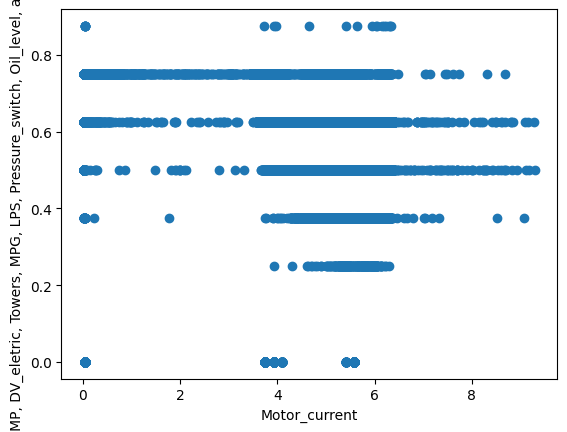

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data["Motor_current"], (data["COMP"] + data["DV_eletric"] + data["Towers"] + data["MPG"] + data["LPS"] + data["Pressure_switch"] + data["Oil_level"] + data["Caudal_impulses"]) / 8)
plt.xlabel("Motor_current")
_ = plt.ylabel("Average of COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, and Caudal_impulses")

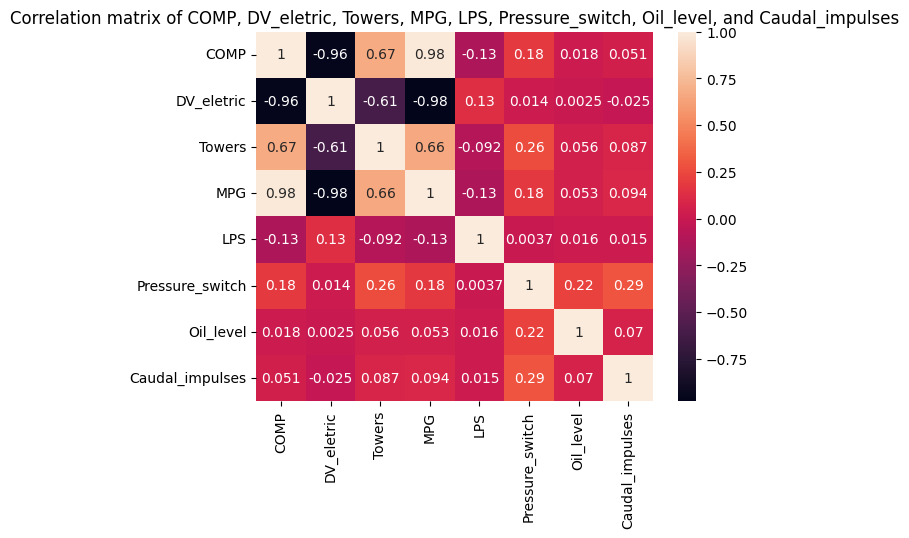

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(df[['COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']].corr(), annot=True)
_ = plt.title('Correlation matrix of COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, and Caudal_impulses')

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


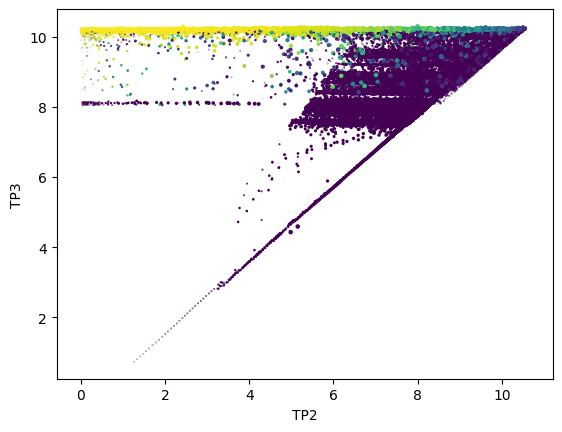

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df['TP2'], df['TP3'], c=df['H1'], s=df['DV_pressure'])
plt.xlabel('TP2')
_ = plt.ylabel('TP3')

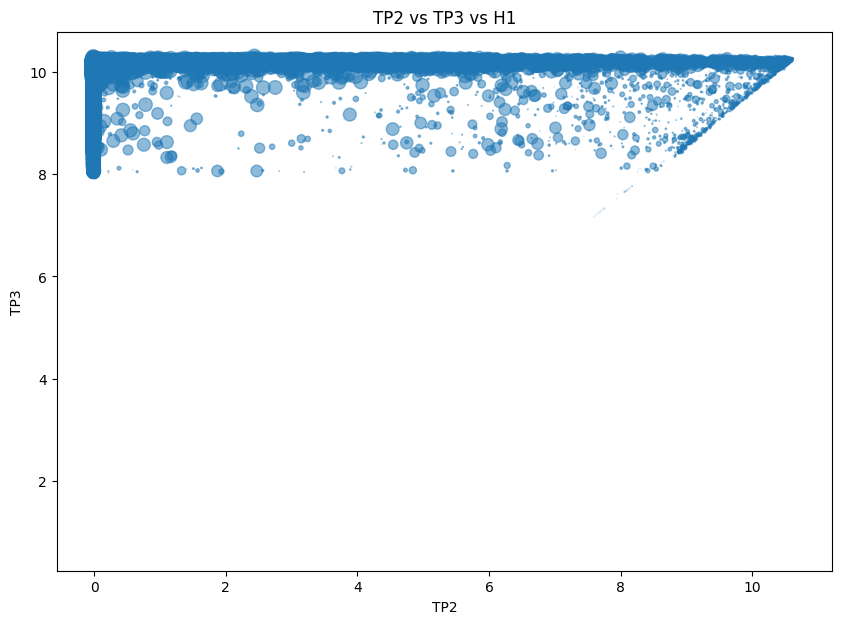

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(df['TP2'], df['TP3'], s=df['H1'] * 10, alpha=0.5)
plt.xlabel('TP2')
plt.ylabel('TP3')
plt.title('TP2 vs TP3 vs H1')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


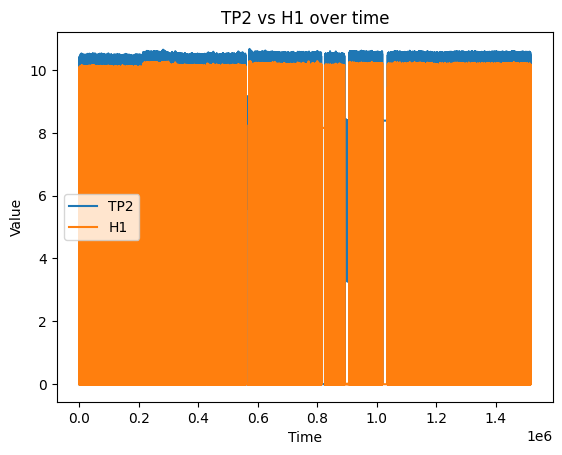

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['TP2'], label='TP2')
plt.plot(df['H1'], label='H1')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('TP2 vs H1 over time')
_ = plt.legend()

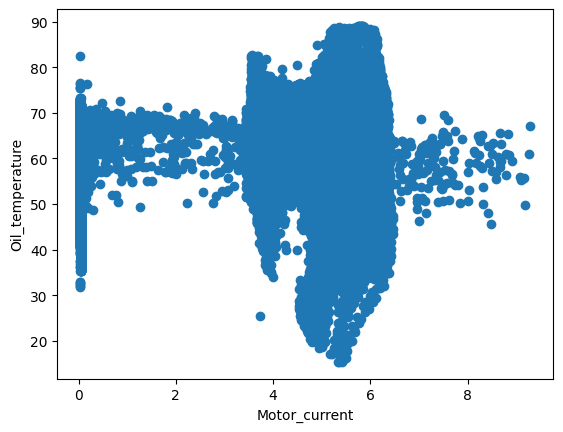

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data["Motor_current"], data["Oil_temperature"])
plt.xlabel("Motor_current")
_ = plt.ylabel("Oil_temperature")

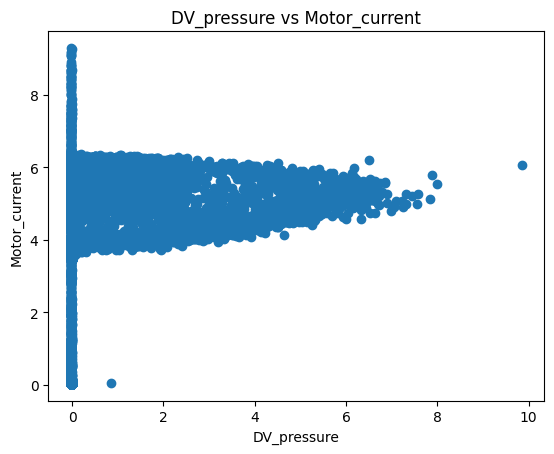

In [ ]:

import matplotlib.pyplot as plt
plt.scatter(data['DV_pressure'], data['Motor_current'])
plt.xlabel('DV_pressure')
plt.ylabel('Motor_current')
_ = plt.title('DV_pressure vs Motor_current')

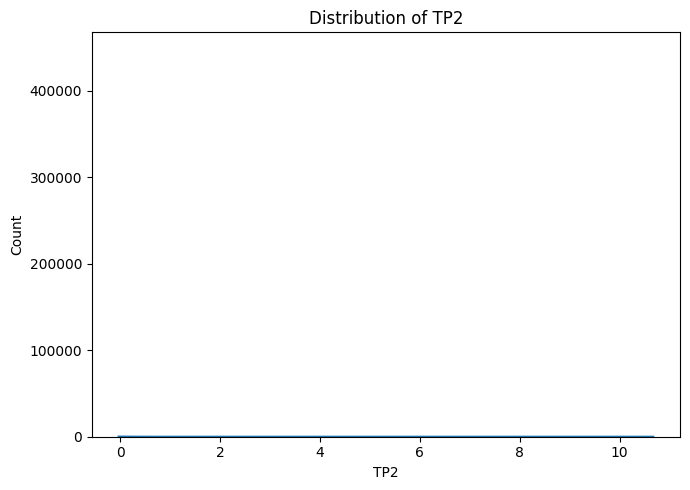

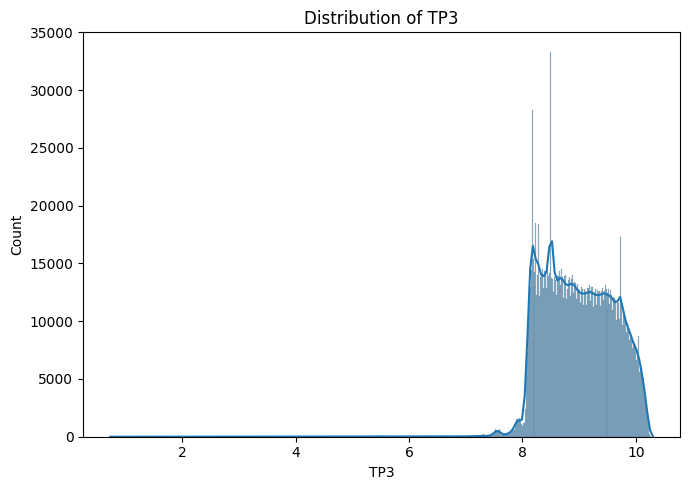

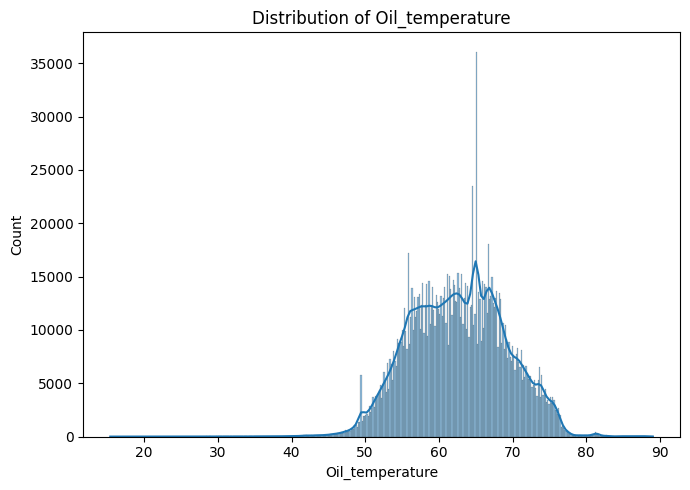

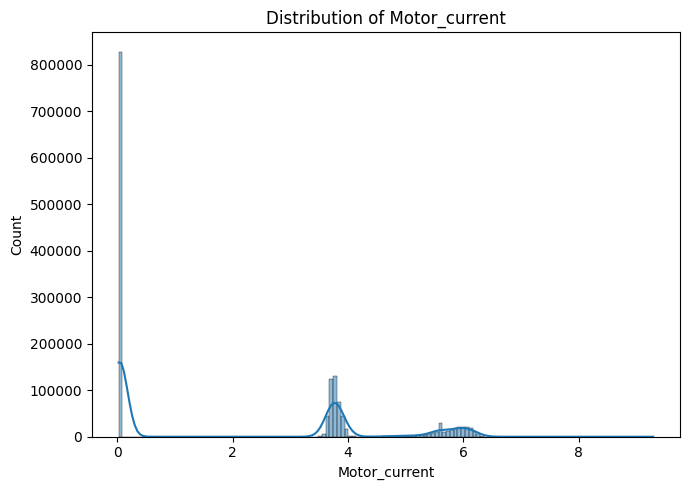

In [ ]:
selected_numerical_features = ['TP2', 'TP3', 'Oil_temperature', 'Motor_current']

for i, feature in enumerate(selected_numerical_features):
    plt.figure(figsize=(7, 5))
    sns.histplot(labeled_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()


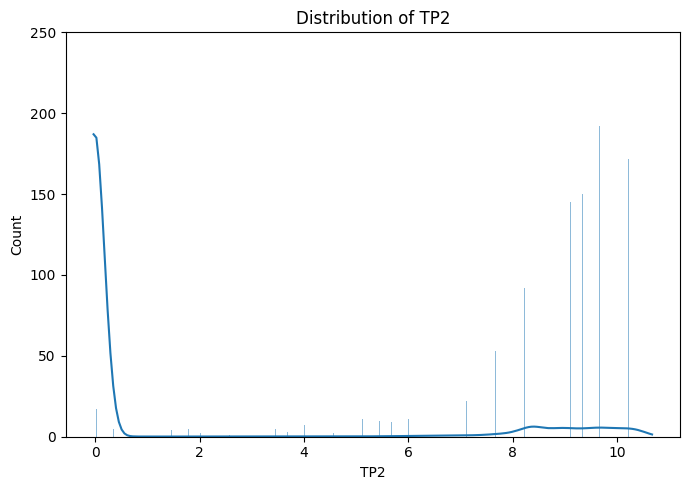

In [ ]:
selected_numerical_features = ['TP2']

for i, feature in enumerate(selected_numerical_features):
    plt.figure(figsize=(7, 5)) # Adjust the figure size as needed
    sns.histplot(labeled_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

    if feature == 'TP2':
        plt.ylim(0, 250)

    plt.tight_layout()
    plt.show()


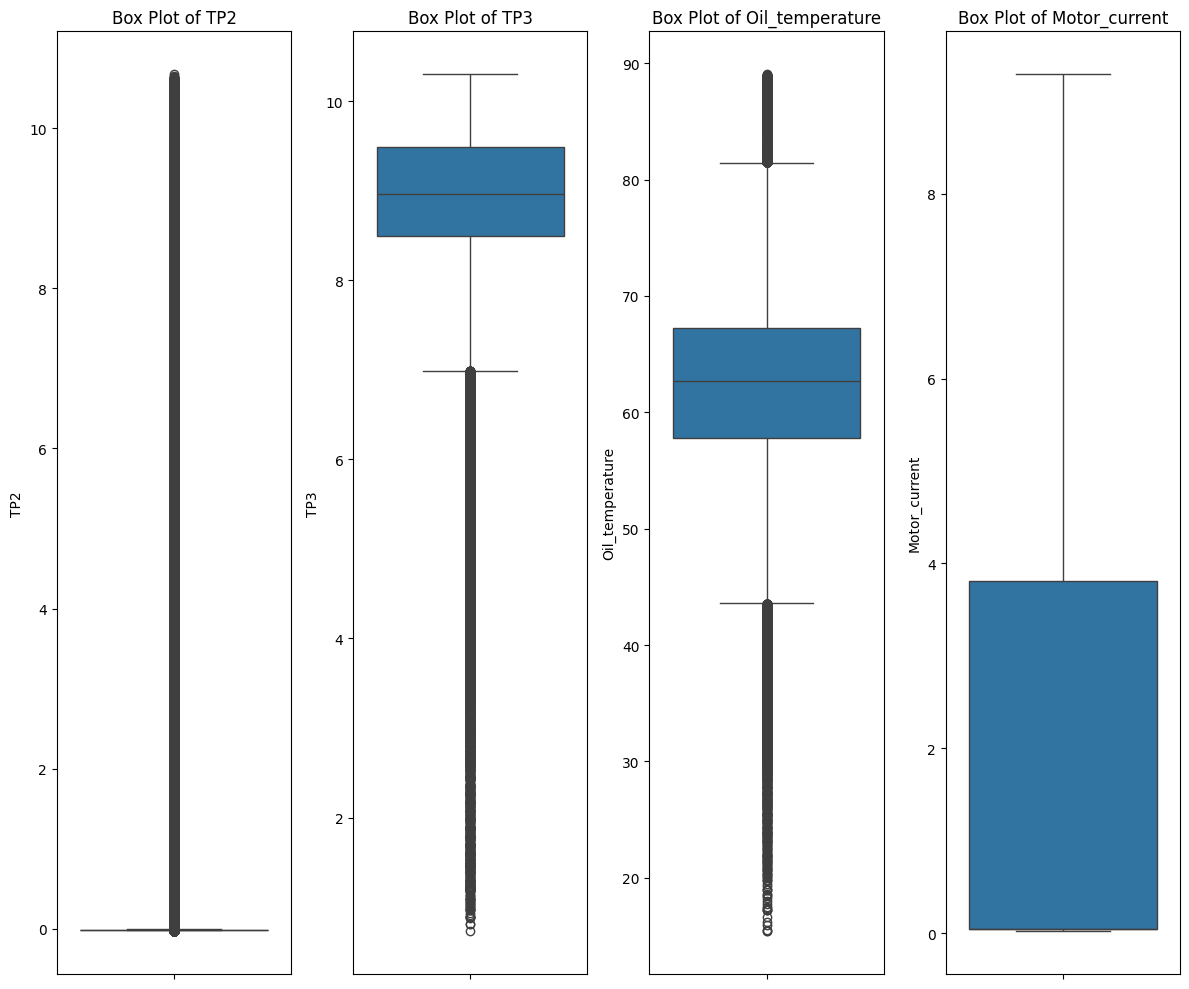

In [ ]:
#  Box Plots for Numerical Features
plt.figure(figsize=(12, 10))
for i, feature in enumerate(selected_numerical_features, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=labeled_data[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()



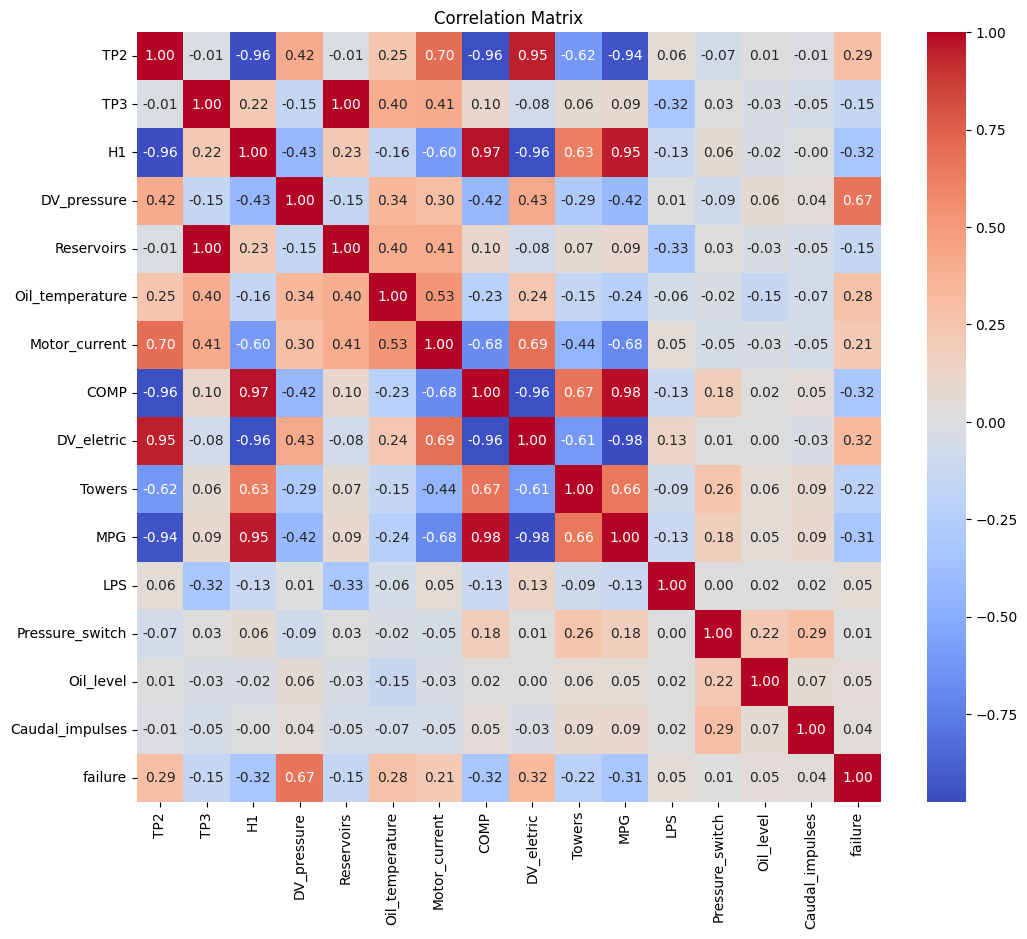

In [ ]:
#  Correlation Analysis
plt.figure(figsize=(12, 10))
correlation_matrix = labeled_data.drop('timestamp', axis=1).corr()  # Dropping timestamp for correlation analysis
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

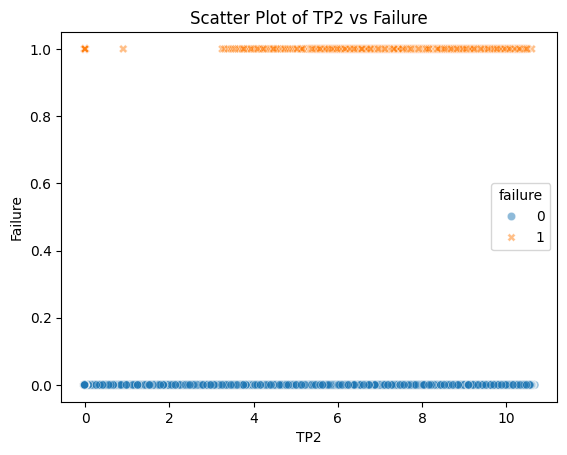

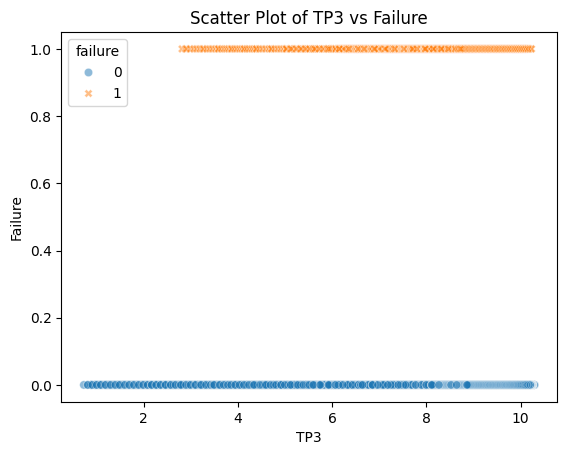

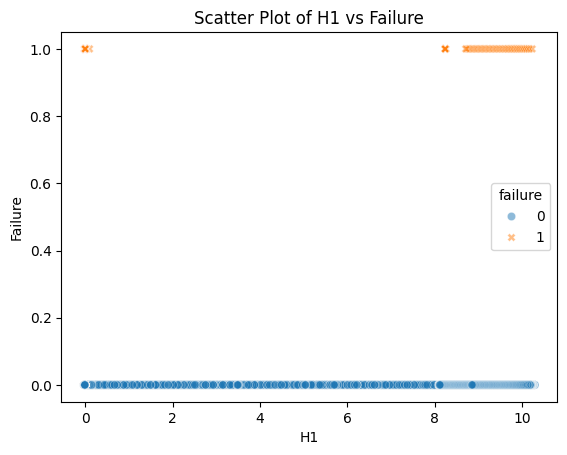

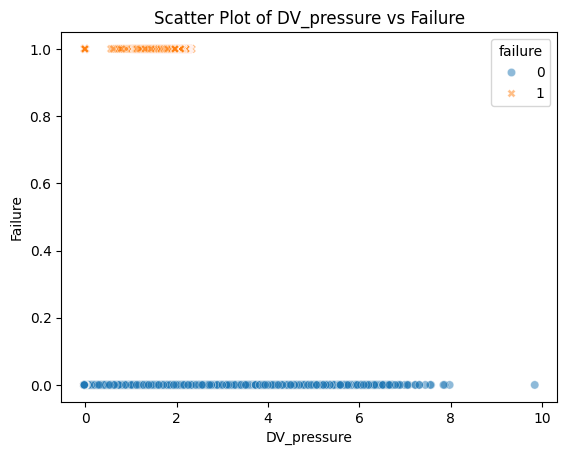

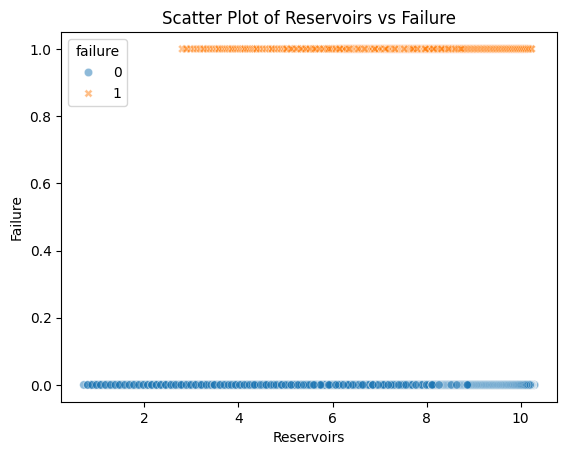

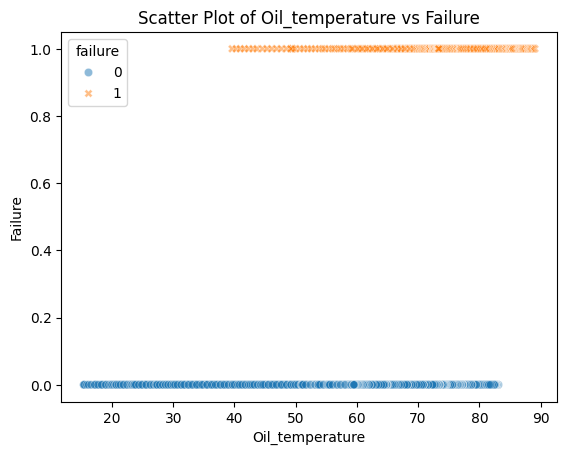

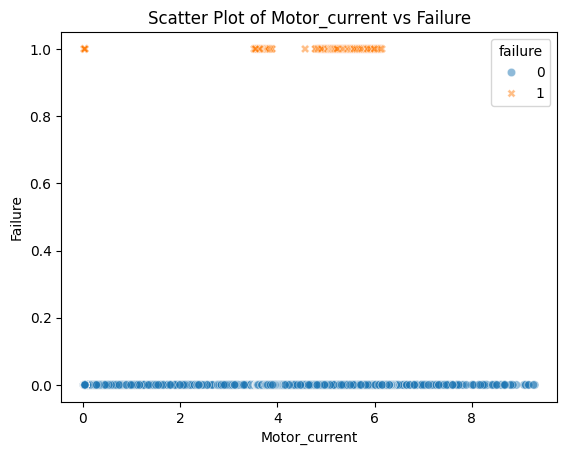

In [ ]:
features = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current']

for feature in features:
    if labeled_data[feature].dtype in ['int64', 'float64']:  # Check if the feature is numeric
        sns.scatterplot(data=labeled_data, x=feature, y='failure', hue='failure', style='failure', alpha=0.5)
        plt.title(f'Scatter Plot of {feature} vs Failure')
        plt.xlabel(feature)
        plt.ylabel('Failure')
        plt.show()


**Time Series Analysis**

In [ ]:
df2 = df
df2['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp column to datetime
df2.set_index('timestamp', inplace=True)  # Set the timestamp column as the DataFrame index
# List of attributes to analyze (excluding the timestamp column)
attributes = df2.columns.tolist()

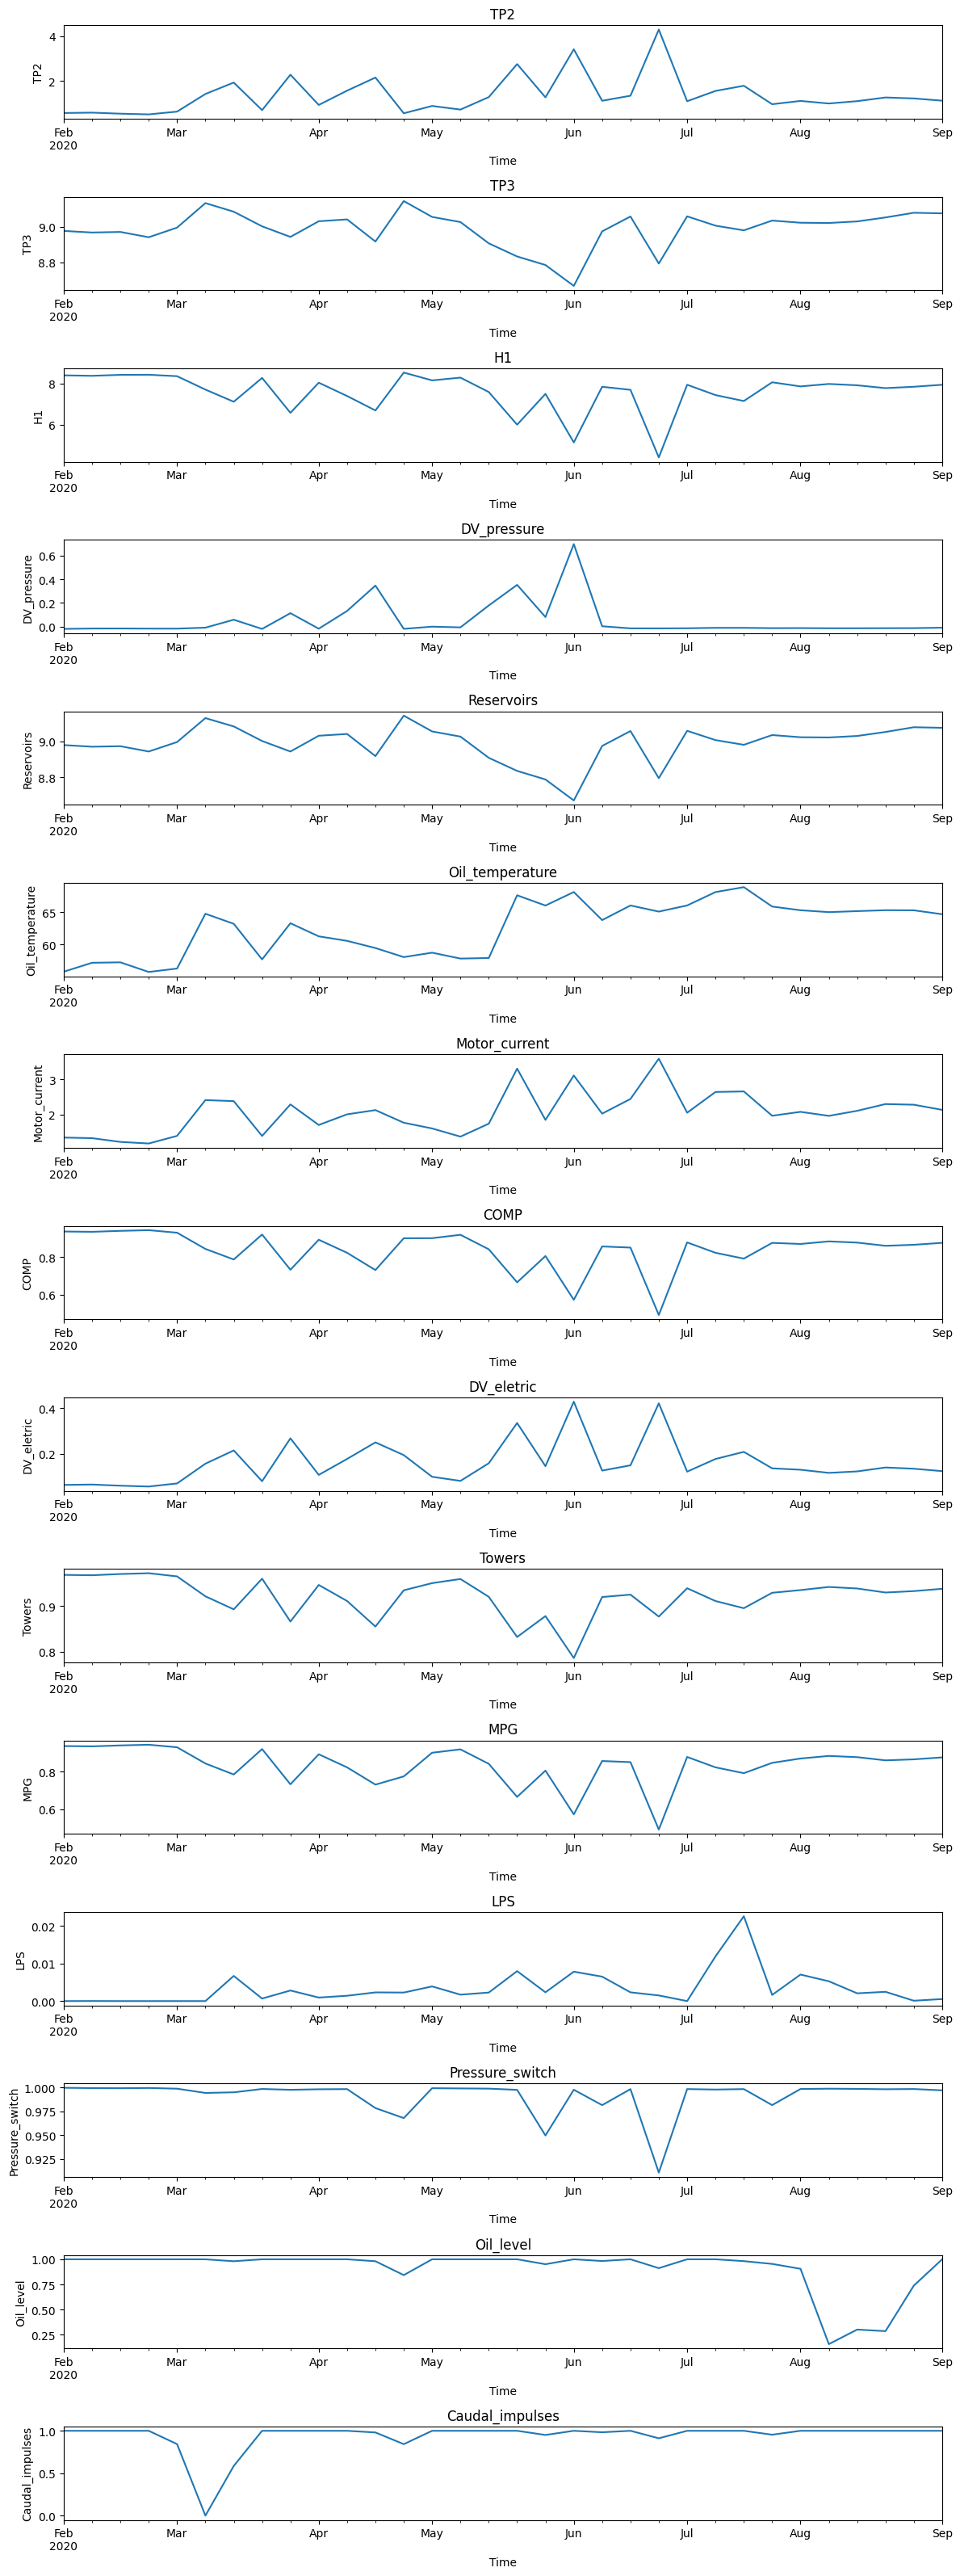

In [ ]:
# Define the resampling frequency
frequency = 'W'
# Plotting
plt.figure(figsize=(12, 32))  # Adjust the figure size as needed

for i, attribute in enumerate(attributes, 1):
    plt.subplot(len(attributes), 1, i)
    df2[attribute].resample(frequency).mean().plot()  # Resample and plot each attribute
    plt.title(attribute)
    plt.xlabel('Time')
    plt.ylabel(attribute)

plt.tight_layout()
plt.show()


#**ML Models**

In [ ]:
df.columns

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses'],
      dtype='object')

In [ ]:
# Split the data into training and testing sets
X = df.drop(['timestamp'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, labeled_data['failure'], test_size=0.2, random_state=42, stratify=labeled_data['failure'])

# Ensure both training and testing sets contain examples of both failure states (0 and 1)
print(f"Training set failure state distribution:\n{y_train.value_counts()}")
print(f"\nTesting set failure state distribution:\n{y_test.value_counts()}")

Training set failure state distribution:
failure
0    1189595
1      23963
Name: count, dtype: int64

Testing set failure state distribution:
failure
0    297399
1      5991
Name: count, dtype: int64


In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
accuracy_nb = accuracy_score(y_test, y_pred)*100
precision_nb = precision_score(y_test, y_pred, average='binary')
recall_nb = recall_score(y_test, y_pred, average='binary')
print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{confusion_matrix}")
print()
from sklearn.metrics import accuracy_score, classification_report

print(classification_report(y_test, y_pred))

Accuracy: 90.93424393330972
Precision: 0.17807610089781958
Recall: 0.9932277756581458
Confusion Matrix:
[[472386  48062]
 [    71  10413]]

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    520448
           1       0.18      0.99      0.30     10484

    accuracy                           0.91    530932
   macro avg       0.59      0.95      0.63    530932
weighted avg       0.98      0.91      0.94    530932



In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print()
accuracy_lr = accuracy_score(y_test, y_pred)*100
precision_lr = precision_score(y_test, y_pred, average='binary')
recall_lr = recall_score(y_test, y_pred, average='binary')
print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")

print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy: 98.72376331610589
Precision: 0.6560659599528857
Recall: 0.7436582109479306
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     74350
           1       0.66      0.74      0.70      1498

    accuracy                           0.99     75848
   macro avg       0.83      0.87      0.85     75848
weighted avg       0.99      0.99      0.99     75848



In [ ]:
# prompt: print an instance when ypred=1

import numpy as np
index = np.where(y_pred == 1)[0][0]
print(f"Example of a data point where y_pred=1:\n{X_test.iloc[index]}")


Example of a data point where y_pred=1:
TP2                 8.3200
TP3                 8.1560
H1                 -0.0100
DV_pressure         2.2120
Reservoirs          8.1580
Oil_temperature    75.0250
Motor_current       5.6925
COMP                0.0000
DV_eletric          1.0000
Towers              0.0000
MPG                 0.0000
LPS                 0.0000
Pressure_switch     1.0000
Oil_level           1.0000
Caudal_impulses     1.0000
Name: 894001, dtype: float64


In [ ]:
from joblib import dump

# Assuming `rf_clf` is your trained Random Forest classifier
# Save the model to a file
dump(model, 'lr_model.joblib')

['lr_model.joblib']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
X_train, X_test, y_train, y_test = train_test_split(X, labeled_data['failure'], test_size=0.05, random_state=42, stratify=labeled_data['failure'])

# Create an instance of the Random Forest classifier
rf_clf = RandomForestClassifier()

# Train the classifier on the training data
rf_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100
precision_rf = precision_score(y_test, y_pred_rf, average='binary')
recall_rf = recall_score(y_test, y_pred_rf, average='binary')
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")

# Print the confusion matrix
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(f"Confusion Matrix:\n{confusion_matrix_rf}")
print()

# Print the classification report
print(classification_report(y_test, y_pred_rf))


Accuracy: 99.94198924164118
Precision: 0.9840213049267643
Recall: 0.986648865153538
Confusion Matrix:
[[74326    24]
 [   20  1478]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74350
           1       0.98      0.99      0.99      1498

    accuracy                           1.00     75848
   macro avg       0.99      0.99      0.99     75848
weighted avg       1.00      1.00      1.00     75848



#**Boosting**

In [ ]:
# Import necessary libraries
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy_ada = accuracy_score(y_test, y_pred)*100
precision_ada = precision_score(y_test, y_pred, average='binary')
recall_ada = recall_score(y_test, y_pred, average='binary')
print(f"Accuracy: {accuracy_ada}")
print(f"Precision: {precision_ada}")
print(f"Recall: {recall_ada}")

# Print the confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{confusion_matrix}")
print()

print(classification_report(y_test, y_pred))

Accuracy: 99.76983869874108
Precision: 0.9313524590163934
Recall: 0.9537390309042351
Confusion Matrix:
[[519711    737]
 [   485   9999]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    520448
           1       0.93      0.95      0.94     10484

    accuracy                           1.00    530932
   macro avg       0.97      0.98      0.97    530932
weighted avg       1.00      1.00      1.00    530932



#**DL**

In [ ]:
X=df

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labeled_data['failure'], test_size=0.35, random_state=42, stratify=labeled_data['failure'])

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=256)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
accuracy_lstm10 = accuracy_score(y_test, y_pred)
precision_lstm10 = precision_score(y_test, y_pred, average='binary')
recall_lstm10 = recall_score(y_test, y_pred, average='binary')
print(f"Accuracy: " ,accuracy_lstm10)
print(f"Precision: {precision_lstm10}")
print(f"Recall: {recall_lstm10}")

# Print the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{confusion_matrix}")
print()

print(classification_report(y_test, y_pred))

Epoch 1/10
3852/3852 [==============================] - 269s 69ms/step - loss: 0.0193 - accuracy: 0.9935
Epoch 2/10
3852/3852 [==============================] - 292s 76ms/step - loss: 0.0077 - accuracy: 0.9974
Epoch 3/10
3852/3852 [==============================] - 290s 75ms/step - loss: 0.0069 - accuracy: 0.9977
Epoch 4/10
3852/3852 [==============================] - 270s 70ms/step - loss: 0.0065 - accuracy: 0.9978
Epoch 5/10
3852/3852 [==============================] - 278s 72ms/step - loss: 0.0063 - accuracy: 0.9978
Epoch 6/10
3852/3852 [==============================] - 270s 70ms/step - loss: 0.0059 - accuracy: 0.9979
Epoch 7/10
3852/3852 [==============================] - 273s 71ms/step - loss: 0.0058 - accuracy: 0.9979
Epoch 8/10
3852/3852 [==============================] - 271s 70ms/step - loss: 0.0054 - accuracy: 0.9980
Epoch 9/10
3852/3852 [==============================] - 270s 70ms/step - loss: 0.0052 - accuracy: 0.9981
Epoch 10/10
16592/16592 [==============================

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall


X = labeled_data.drop(['failure', 'timestamp'], axis=1).values  # Dropping non-numeric or target columns
y = labeled_data['failure'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape X_scaled for RNN [samples, time steps, features]
# This is a required step for RNNs, here we assume each sample is a single time step
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=42)

# Build the RNN Model
model = Sequential([
    SimpleRNN(50, input_shape=(1, X_train.shape[2]), activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])


# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model and include precision and recall in the evaluation
test_loss, test_acc_rnn, test_precision, test_recall = model.evaluate(X_test, y_test)

# Print Test Accuracy, Precision, and Recall
print(f'Test Accuracy: {test_acc_rnn}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')


Epoch 1/10
12326/12326 [==============================] - 102s 8ms/step - loss: 0.0214 - accuracy: 0.9924 - precision: 0.7726 - recall: 0.8672 - val_loss: 0.0118 - val_accuracy: 0.9954 - val_precision: 0.8428 - val_recall: 0.9428
Epoch 2/10
12326/12326 [==============================] - 102s 8ms/step - loss: 0.0119 - accuracy: 0.9957 - precision: 0.8716 - recall: 0.9144 - val_loss: 0.0094 - val_accuracy: 0.9970 - val_precision: 0.9288 - val_recall: 0.9156
Epoch 3/10
12326/12326 [==============================] - 93s 8ms/step - loss: 0.0107 - accuracy: 0.9960 - precision: 0.8833 - recall: 0.9180 - val_loss: 0.0090 - val_accuracy: 0.9972 - val_precision: 0.9059 - val_recall: 0.9573
Epoch 4/10
12326/12326 [==============================] - 81s 7ms/step - loss: 0.0105 - accuracy: 0.9963 - precision: 0.8917 - recall: 0.9225 - val_loss: 0.0087 - val_accuracy: 0.9969 - val_precision: 0.8853 - val_recall: 0.9669
Epoch 5/10
12326/12326 [==============================] - 86s 7ms/step - loss: 0.0

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your features and target variable, prepared as described previously
# Let's also assume X has been scaled and reshaped for LSTM [samples, time steps, features]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=42)

# Building the BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])


# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluating the model

test_loss, test_acc_bilstm, test_precision_bilstm, test_recall_bilstm = model.evaluate(X_test, y_test)

# Print Test Accuracy, Precision, and Recall
print(f'Test Accuracy: {test_acc_bilstm}')
print(f'Test Precision: {test_precision_bilstm}')
print(f'Test Recall: {test_recall_bilstm}')


Epoch 1/10
12326/12326 [==============================] - 117s 9ms/step - loss: 0.0173 - accuracy: 0.9943 - precision_1: 0.8299 - recall_1: 0.8909 - val_loss: 0.0088 - val_accuracy: 0.9958 - val_precision_1: 0.8405 - val_recall_1: 0.9718
Epoch 2/10
12326/12326 [==============================] - 100s 8ms/step - loss: 0.0086 - accuracy: 0.9967 - precision_1: 0.9034 - recall_1: 0.9312 - val_loss: 0.0080 - val_accuracy: 0.9962 - val_precision_1: 0.8507 - val_recall_1: 0.9749
Epoch 3/10
12326/12326 [==============================] - 96s 8ms/step - loss: 0.0078 - accuracy: 0.9971 - precision_1: 0.9176 - recall_1: 0.9359 - val_loss: 0.0063 - val_accuracy: 0.9979 - val_precision_1: 0.9368 - val_recall_1: 0.9591
Epoch 4/10
12326/12326 [==============================] - 97s 8ms/step - loss: 0.0073 - accuracy: 0.9972 - precision_1: 0.9225 - recall_1: 0.9377 - val_loss: 0.0059 - val_accuracy: 0.9979 - val_precision_1: 0.9588 - val_recall_1: 0.9347
Epoch 5/10
12326/12326 [==========================

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your features and target variable
# Let's also assume X has been scaled

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
print(f"X_train shape before reshaping: {X_train.shape}")
print(f"X_test shape before reshaping: {X_test.shape}")

X_train shape before reshaping: (1213558, 1, 15)
X_test shape before reshaping: (303390, 1, 15)


In [ ]:
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Change input_shape to match X_train
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
model = models.Sequential([
    layers.Flatten(input_shape=(1, 15)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
15170/15170 [==============================] - 72s 5ms/step - loss: 0.0137 - accuracy: 0.9951 - precision_6: 0.8526 - recall_6: 0.9103 - val_loss: 0.0085 - val_accuracy: 0.9966 - val_precision_6: 0.8860 - val_recall_6: 0.9459
Epoch 2/10
15170/15170 [==============================] - 64s 4ms/step - loss: 0.0081 - accuracy: 0.9970 - precision_6: 0.9117 - recall_6: 0.9373 - val_loss: 0.0083 - val_accuracy: 0.9965 - val_precision_6: 0.8806 - val_recall_6: 0.9516
Epoch 3/10
15170/15170 [==============================] - 65s 4ms/step - loss: 0.0073 - accuracy: 0.9973 - precision_6: 0.9234 - recall_6: 0.9412 - val_loss: 0.0063 - val_accuracy: 0.9979 - val_precision_6: 0.9349 - val_recall_6: 0.9579
Epoch 4/10
15170/15170 [==============================] - 64s 4ms/step - loss: 0.0069 - accuracy: 0.9975 - precision_6: 0.9326 - recall_6: 0.9430 - val_loss: 0.0079 - val_accuracy: 0.9968 - val_precision_6: 0.9818 - val_recall_6: 0.8525
Epoch 5/10
15170/15170 [============================

In [ ]:
test_loss, test_acc_ann, test_precision_ann, test_recall_ann = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc_ann}')
print(f'Test Precision: {test_precision_ann}')
print(f'Test Recall: {test_recall_ann}')

9481/9481 [==============================] - 26s 3ms/step - loss: 0.0050 - accuracy: 0.9982 - precision_6: 0.9482 - recall_6: 0.9636
Test Accuracy: 0.9982267022132874
Test Precision: 0.9482421875
Test Recall: 0.9636123180389404


#**custom**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
corr = labeled_data.corr()
high_corr = corr[abs(corr['failure'])>0.07]
features = high_corr.index.drop('failure')
print(features.shape)
print(features)

<ipython-input-19-ab2f74f7d944>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = labeled_data.corr()


(11,)
Index(['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG'],
      dtype='object')


In [ ]:
labeled_data[features] = labeled_data[features].apply(pd.to_numeric, errors='coerce')


# Now your categorical columns are encoded and ready for model training

# Drop rows with missing values
labeled_data = labeled_data.dropna()

# Separating features and target variable
X = torch.tensor(labeled_data[features].values.astype(np.float32), dtype=torch.float32)
Y = torch.tensor(labeled_data['failure'].values.astype(np.float32), dtype=torch.float32).view(-1, 1)

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), Y.numpy(), test_size=0.2, random_state=0)

# Standardize the input features
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

In [ ]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetworkModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)  # Shifted layer with 2048 units
        # self.layer2 = nn.Linear(2048, 1024)
        # self.layer3 = nn.Linear(1024, 512)
        # self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, 128)
        self.layer6 = nn.Linear(128, 64)
        self.layer7 = nn.Linear(64, 32)
        self.layer8 = nn.Linear(32, 16)
        self.layer9 = nn.Linear(16, 8)
        self.layer10 = nn.Linear(8, 4)
        self.layer11 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        # x = torch.relu(self.layer2(x))
        # x = torch.relu(self.layer3(x))
        # x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x = torch.relu(self.layer6(x))
        x = torch.relu(self.layer7(x))
        x = torch.relu(self.layer8(x))
        x = torch.relu(self.layer9(x))
        x = torch.relu(self.layer10(x))
        x = self.layer11(x)  # Output before applying sigmoid since BCEWithLogitsLoss is used
        return x


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Adjusted training function to include precision and recall
def train_model(model, X_train, y_train, X_val, y_val, lr=0.005, epochs=20, clip_value=0.1, patience=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_accuracy = 0
    best_epoch = 0
    no_improvement_count = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        # Evaluate on validation set for early stopping
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_predicted = torch.sigmoid(val_outputs) > 0.5
            val_accuracy = accuracy_score(y_val, val_predicted.numpy())

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_epoch = epoch
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        print(f'Epoch {epoch + 1}: Loss = {loss.item():.4f}, Validation Loss = {val_loss.item():.4f}, Validation Accuracy = {val_accuracy:.4f}')

        # Early stopping check
        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    print(f'Best Accuracy during training: {best_accuracy:.4f} at epoch {best_epoch + 1}')

    # Final evaluation on test set
    model.eval()
    with torch.no_grad():
        final_outputs = model(X_test)
        final_predicted = torch.sigmoid(final_outputs) > 0.5
        final_accuracy = accuracy_score(y_test, final_predicted.numpy())
        final_precision = precision_score(y_test, final_predicted.numpy())
        final_recall = recall_score(y_test, final_predicted.numpy())

    print(f'Final Accuracy on test set: {final_accuracy:.4f}')
    print(f'Final Precision on test set: {final_precision:.4f}')
    print(f'Final Recall on test set: {final_recall:.4f}')

# Assuming you have already initialized and trained your model,
# and have the final X_test and y_test tensors prepared.
# You would call the evaluation like this (adjusting as necessary for your actual variable names):
# train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)


In [ ]:
# Initialize the model
model = NeuralNetworkModel(X_train.shape[1])

# Convert numpy arrays back to tensors for training and evaluation
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Train the model and print final accuracy
train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

<ipython-input-34-bd943878cdcd>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-34-bd943878cdcd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


Epoch 1: Loss = 0.8605, Validation Loss = 0.8486, Validation Accuracy = 0.0200
Epoch 2: Loss = 0.8487, Validation Loss = 0.8299, Validation Accuracy = 0.0200
Epoch 3: Loss = 0.8299, Validation Loss = 0.8052, Validation Accuracy = 0.0200
Epoch 4: Loss = 0.8053, Validation Loss = 0.7749, Validation Accuracy = 0.0200
Epoch 5: Loss = 0.7749, Validation Loss = 0.7571, Validation Accuracy = 0.0200
Epoch 6: Loss = 0.7571, Validation Loss = 0.7478, Validation Accuracy = 0.0200
Epoch 7: Loss = 0.7478, Validation Loss = 0.7452, Validation Accuracy = 0.0200
Epoch 8: Loss = 0.7452, Validation Loss = 0.7426, Validation Accuracy = 0.0200
Epoch 9: Loss = 0.7427, Validation Loss = 0.7401, Validation Accuracy = 0.0200
Epoch 10: Loss = 0.7401, Validation Loss = 0.7374, Validation Accuracy = 0.0200
Epoch 11: Loss = 0.7374, Validation Loss = 0.7238, Validation Accuracy = 0.0209
Epoch 12: Loss = 0.7238, Validation Loss = 0.6969, Validation Accuracy = 0.2549
Epoch 13: Loss = 0.6969, Validation Loss = 0.6596

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**Hybrid**

In [ ]:
# Preprocess the data
data = labeled_data

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.sort_values('timestamp', inplace=True)
data.drop(columns=['timestamp'], inplace=True)

In [ ]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.metrics import Precision, Recall



# Split data into features and target
X = data.drop('failure', axis=1).values
y = data['failure'].values

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, shuffle=False)

# Convert data into sequences for LSTM
sequence_length = 10
train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=512)
test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=512)

# Step 2: LSTM Model Definition and Training
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X_train.shape[1])),
    LSTM(units=50),
    Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

model.fit_generator(train_generator, epochs=30, validation_data=test_generator)

# Step 3: Feature Extraction with LSTM
# Modify the LSTM model to output features from the last LSTM layer
feature_extractor = Sequential(model.layers[:-1])
features_train = feature_extractor.predict_generator(train_generator)
features_test = feature_extractor.predict_generator(test_generator)

# Adjust features shape
features_train = np.squeeze(features_train)
features_test = np.squeeze(features_test)

# Step 4: Random Forest Model Training
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(features_train, y_train[sequence_length:])
y_pred = rf_model.predict(features_test)





Epoch 1/30


<ipython-input-43-ea925b846bb7>:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=30, validation_data=test_generator)


1926/1926 [==============================] - 29s 13ms/step - loss: 0.0784 - accuracy: 0.9696 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0440 - val_accuracy: 0.9969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
1926/1926 [==============================] - 26s 13ms/step - loss: 0.0591 - accuracy: 0.9707 - precision: 0.4561 - recall: 0.1084 - val_loss: 0.0155 - val_accuracy: 0.9969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
1926/1926 [==============================] - 21s 11ms/step - loss: 0.0523 - accuracy: 0.9734 - precision: 0.5418 - recall: 0.4756 - val_loss: 0.0165 - val_accuracy: 0.9969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
1926/1926 [==============================] - 20s 11ms/step - loss: 0.0519 - accuracy: 0.9698 - precision: 0.4453 - recall: 0.2077 - val_loss: 0.0172 - val_accuracy: 0.9969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
1926/1926 [==============================] - 21s

<ipython-input-43-ea925b846bb7>:45: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  features_train = feature_extractor.predict_generator(train_generator)
<ipython-input-43-ea925b846bb7>:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  features_test = feature_extractor.predict_generator(test_generator)


#**Comparision**

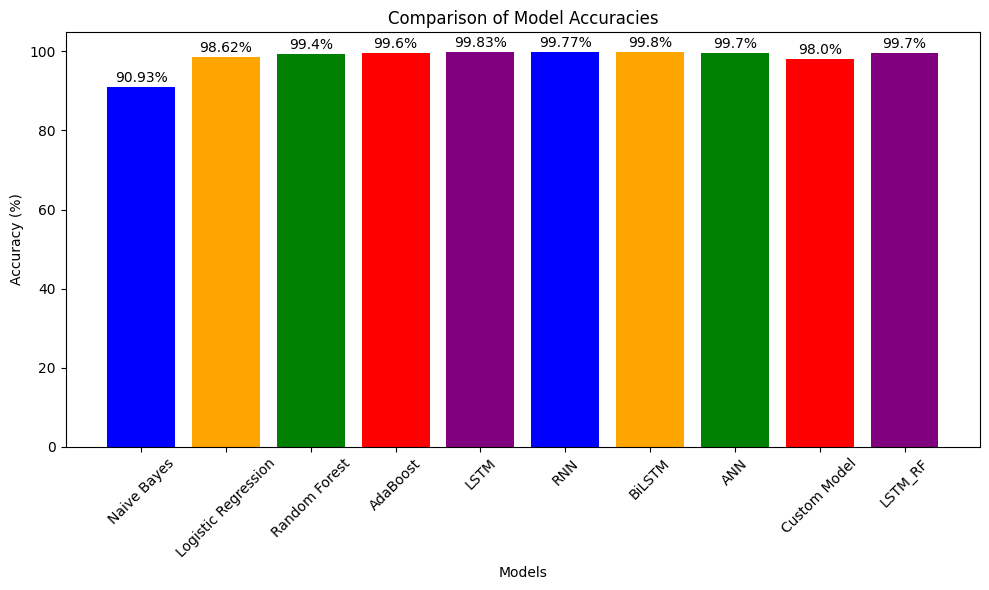

In [ ]:
# Model names
models = ['Naive Bayes','Logistic Regression', 'Random Forest','AdaBoost','LSTM', 'RNN', 'BiLSTM','ANN', 'Custom Model', 'LSTM_RF']
# Accuracies
accuracies = [90.93, 98.62, 99.4, 99.6, 99.83, 99.77, 99.80, 99.7, 98.00, 99.7]

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)

# Adding the text labels on the bars
for i in range(len(models)):
    plt.text(i, accuracies[i] + 0.5, f"{accuracies[i]}%", ha = 'center', va = 'bottom')

plt.tight_layout()
plt.show()


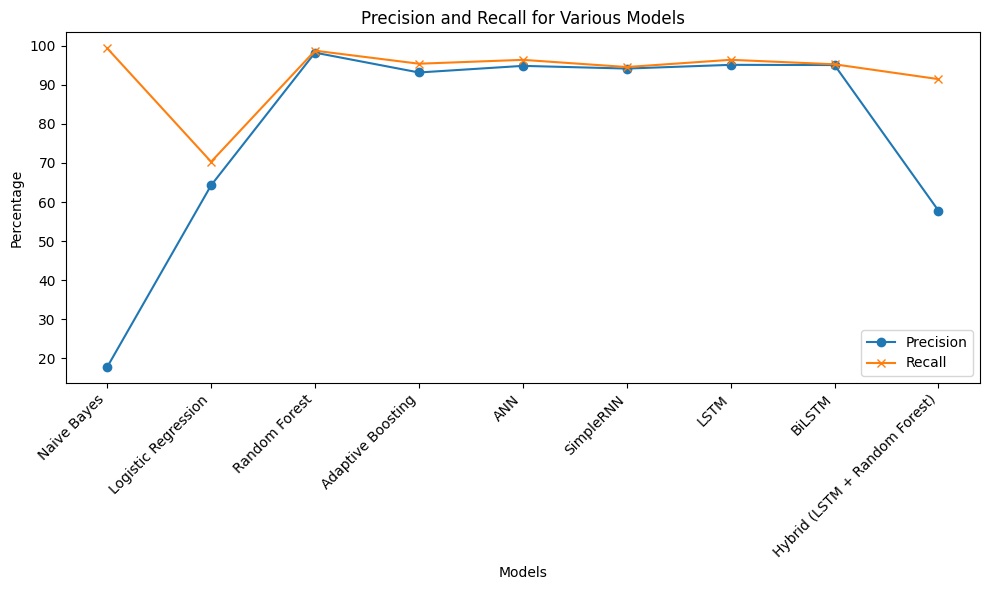

In [ ]:
import matplotlib.pyplot as plt

# Plotting Precision and Recall
plt.figure(figsize=(10, 6))

# Plotting both precision and recall for each model
plt.plot(df['Model'], df['Precision'], label='Precision', marker='o')
plt.plot(df['Model'], df['Recall'], label='Recall', marker='x')

# Adding title and labels
plt.title('Precision and Recall for Various Models')
plt.xlabel('Models')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha="right")  # Rotate labels to avoid overlap
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
